In [1]:
import sys
import os
import matplotlib.pyplot as plt
import json
import numpy as np
sys.path.append(os.environ["CODE_REPOSITORY"])
from code_repository.hotones.thetools import *

In [2]:
external = os.path.join("/media","jofrony","2TB", 
                        "dardel", "current_bgd2","plateaus_with_inhibition", 
                        "supercomputer", "networks")
repository = os.path.join("/home","jofrony","Documents",
                          "Repositories","current_bgd2",
                          "plateaus_with_inhibition","supercomputer","networks")

In [3]:
folder = "dendrite_traces"

In [4]:
plateau_ids = os.path.join(repository,
                           "pdc_network_2022-10-04",
                          "cell_ids_plateaus.json")
with open(plateau_ids) as f:
    plateau_ids = json.load(f)

In [5]:
e = Experiments()
e.add_experiment(name="plateaus_without_inhibition",
                 color="black",
                 external_input_file="external-whole-network-plateaus-2022-10-04-18-05-10.hdf5",
                 label="plateaus without inhibition",
                 network="network-synapses.hdf5",
                 path=os.path.join(external, "pdc_network_2022-10-04"),
                 output="network_output_modified_GABA_input-spikes_no_inhibition.hdf5")
e.add_experiment(name="plateaus_with_inhibition",
                 color="red",
                 external_input_file="external-whole-network-plateaus-2022-10-04-18-05-10.hdf5",
                 label="plateaus with inhibition",
                 network="network-synapses.hdf5",
                 path=os.path.join(external, "pdc_network_2022-10-04"),
                 output="network_output_modified_GABA_input-spikes_cell_ids_current_injection_dardel_2022-10-04-18-10-06_plateau_inhibition_p1.hdf5")

e.experiments     

{'plateaus_without_inhibition': {'color': 'black',
  'external_input_file': 'external-whole-network-plateaus-2022-10-04-18-05-10.hdf5',
  'label': 'plateaus without inhibition',
  'network': 'network-synapses.hdf5',
  'path': '/media/jofrony/2TB/dardel/current_bgd2/plateaus_with_inhibition/supercomputer/networks/pdc_network_2022-10-04',
  'output': 'network_output_modified_GABA_input-spikes_no_inhibition.hdf5'},
 'plateaus_with_inhibition': {'color': 'red',
  'external_input_file': 'external-whole-network-plateaus-2022-10-04-18-05-10.hdf5',
  'label': 'plateaus with inhibition',
  'network': 'network-synapses.hdf5',
  'path': '/media/jofrony/2TB/dardel/current_bgd2/plateaus_with_inhibition/supercomputer/networks/pdc_network_2022-10-04',
  'output': 'network_output_modified_GABA_input-spikes_cell_ids_current_injection_dardel_2022-10-04-18-10-06_plateau_inhibition_p1.hdf5'}}

In [6]:
with open(os.path.join("expected_case","unexpected_case_SPN.json")) as f:
    k = json.load(f)

In [7]:
sl = LoadSimulations(experiments=e)
sl.load_network_file(load_synapses=False)

Loading 40000 neurons with 35040256 synapses and 2531 gap junctions
Loading /media/jofrony/2TB/dardel/current_bgd2/plateaus_with_inhibition/supercomputer/networks/pdc_network_2022-10-04/simulation/network_output_modified_GABA_input-spikes_no_inhibition.hdf5
Loading 40000 neurons with 35040256 synapses and 2531 gap junctions
Loading /media/jofrony/2TB/dardel/current_bgd2/plateaus_with_inhibition/supercomputer/networks/pdc_network_2022-10-04/simulation/network_output_modified_GABA_input-spikes_cell_ids_current_injection_dardel_2022-10-04-18-10-06_plateau_inhibition_p1.hdf5


In [8]:
sample_ids = k['plateau_inhibited_by'][::10]
sample_ids_per_exp = {k:sample_ids for k in e.experiments}

In [9]:
%%time
neuron_type = "SPN"
dvoltage_synapse = dendrite_voltage_synapse_location(data_obj=sl, neuron_type=neuron_type, external_input_name="cortical_signal_100",
                                        specific_trace_ids=sample_ids_per_exp, interval=[0.5, 2.5], dt_step=0.5)

CPU times: user 5.99 s, sys: 350 ms, total: 6.34 s
Wall time: 18.1 s


In [10]:
def change_dendrite(dvoltage_synase,control,specific_trace_ids, dx, parameters):

    tmp = dict()
    for s in specific_trace_ids:
        per_cell = dict()
        for experiment in dvoltage_synapse:
            for sec_id in dvoltage_synapse[control][s]:
                vc = dvoltage_synapse[control][s][sec_id]['voltage']
                v = dvoltage_synapse[experiment][s][sec_id]['voltage']
                
                start = int(parameters["start"] / dx)
                stop = int(parameters["stop"] / dx)
                
                v_diff = (v - np.mean(v[:start])) - (vc - np.mean(vc[:start]))
                v_section = v_diff[start:stop]
                auc = AUC(v_section, dx)
                plt.plot(v_section)
                per_cell.update({experiment: {sec_id: auc}})
        tmp.update({s: per_cell})
    return tmp


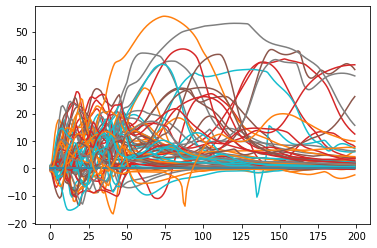

In [11]:
change = change_dendrite(dvoltage_synase=dvoltage_synapse, control="plateaus_without_inhibition", 
                         specific_trace_ids=sample_ids, dx=0.5e-3, parameters={"start": 0.5, "stop":0.6})

In [12]:
changes = [[*change[k]['plateaus_with_inhibition'].values()][0] for k in change]

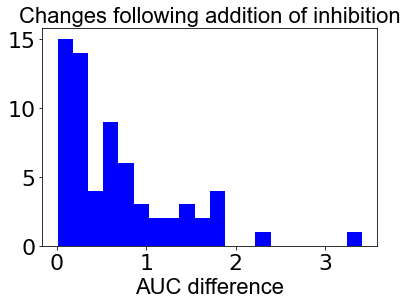

In [13]:
csfont = {"fontname": "Arial",
              'fontsize': 22}
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.title("Changes following addition of inhibition", **csfont)
ax.hist(changes, bins=20, color="blue")
plt.xlabel("AUC difference", **csfont)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.savefig(os.path.join("auc","histogram_changes_dendrite_potential.svg"))


In [14]:
colors = {"plateaus_without_inhibition": 'black', 
      "plateaus_with_inhibition": 'red'}

/home/jofrony/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


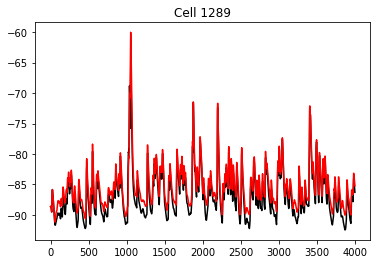

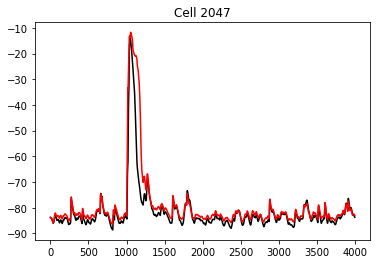

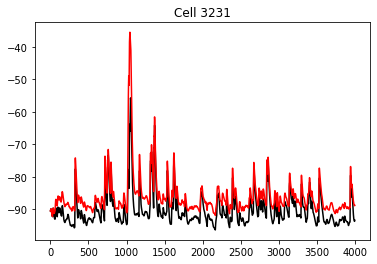

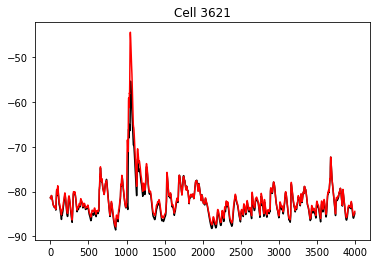

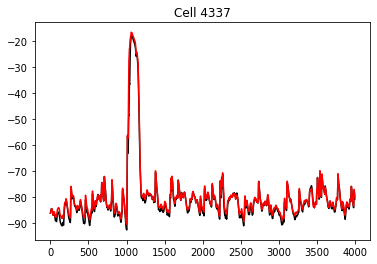

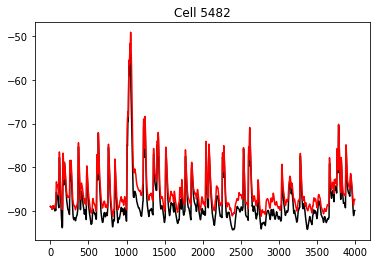

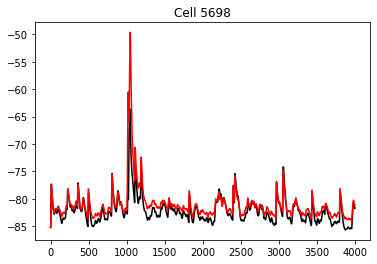

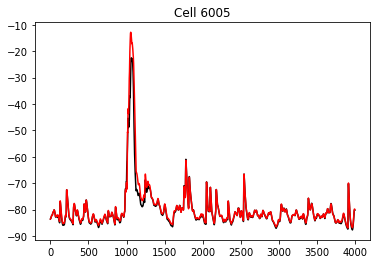

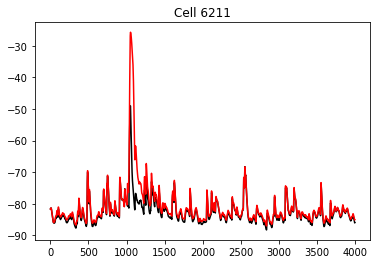

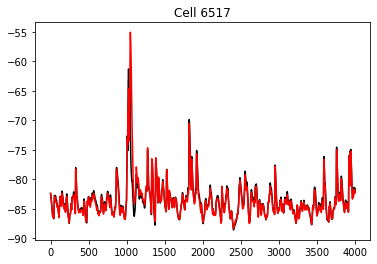

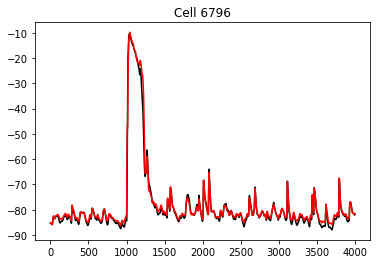

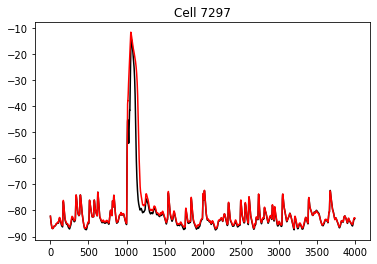

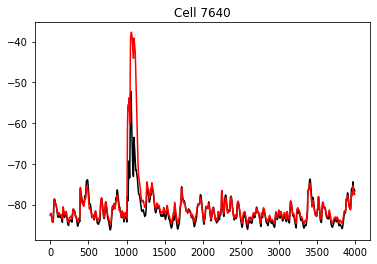

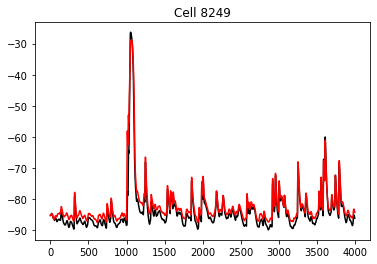

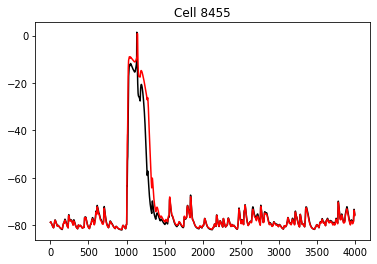

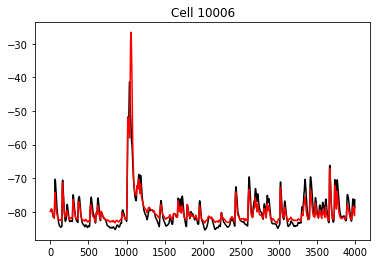

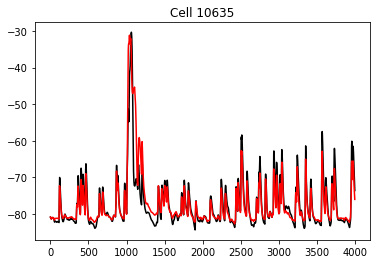

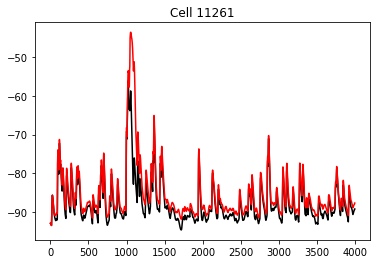

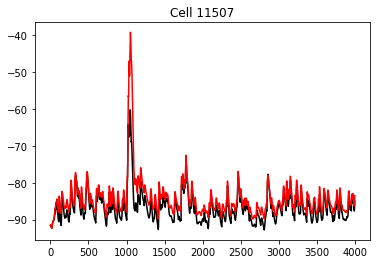

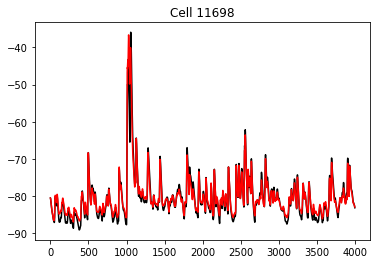

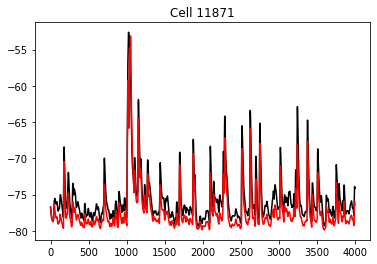

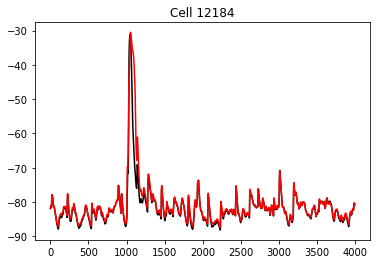

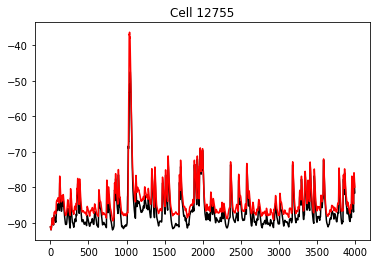

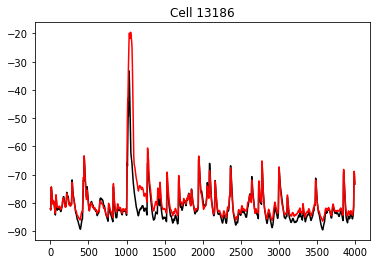

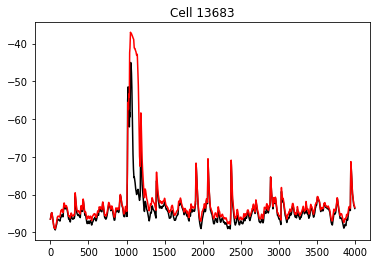

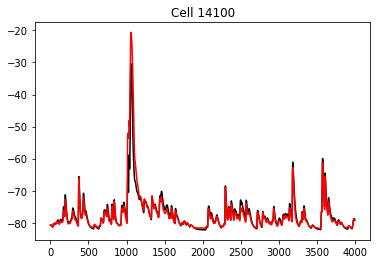

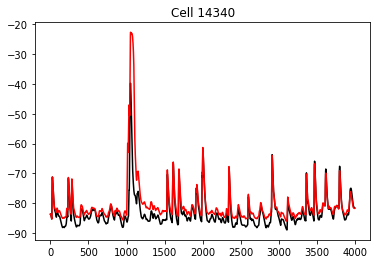

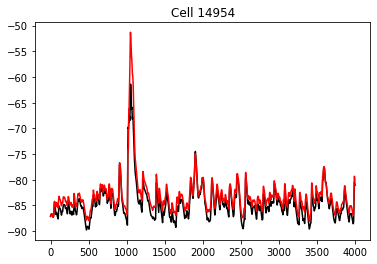

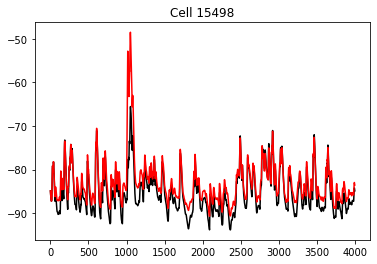

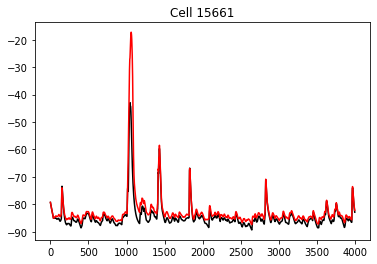

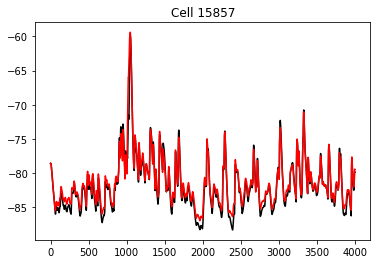

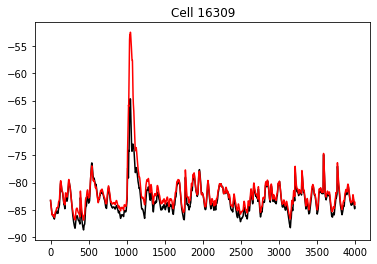

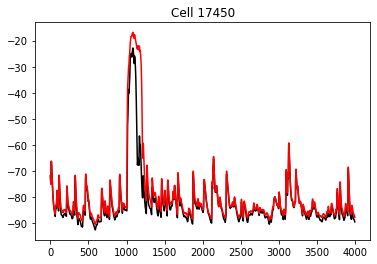

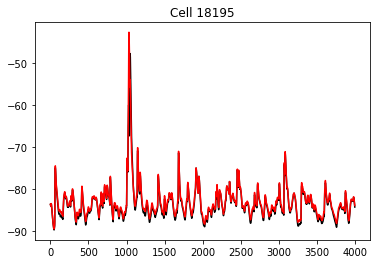

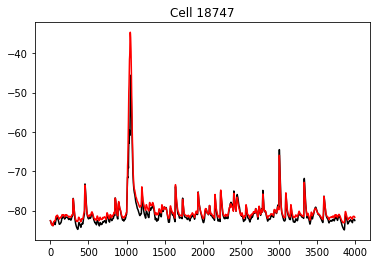

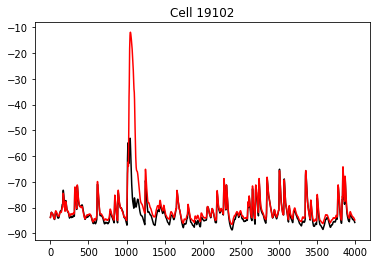

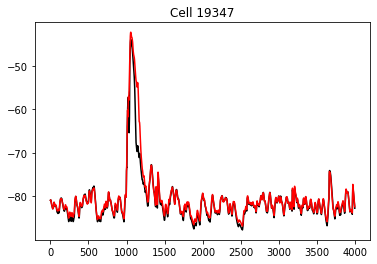

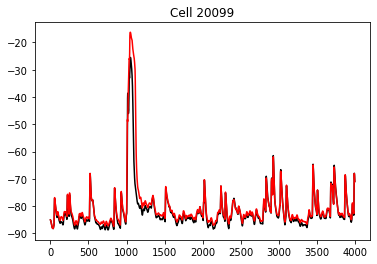

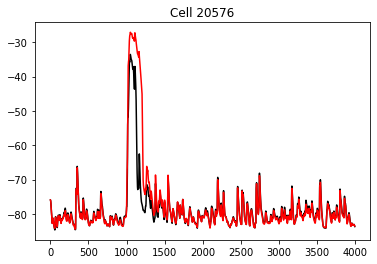

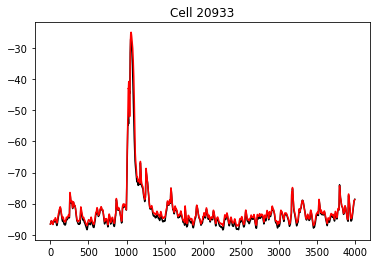

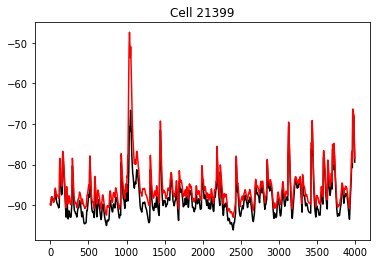

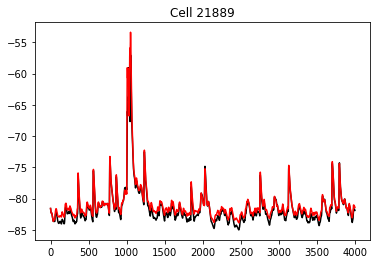

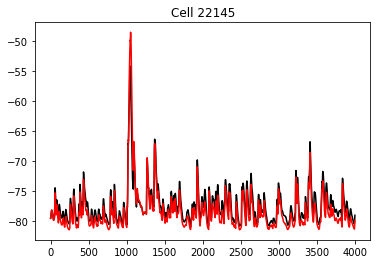

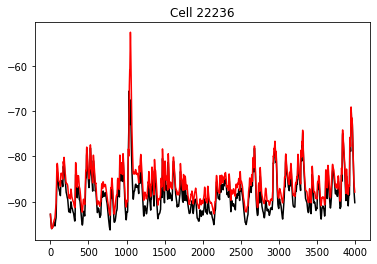

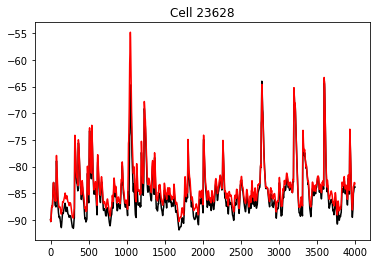

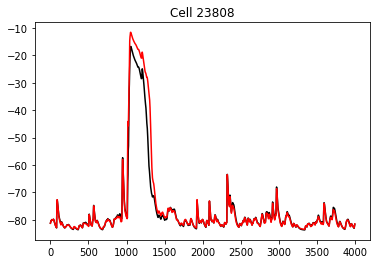

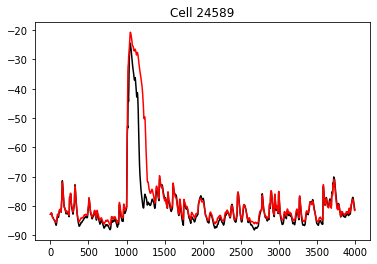

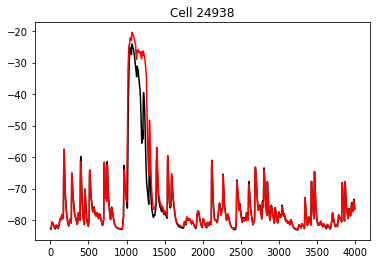

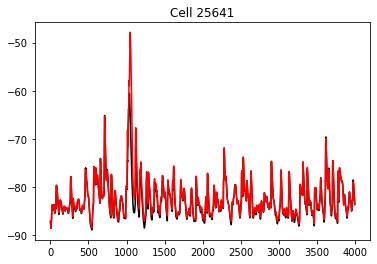

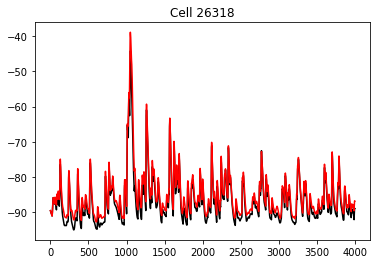

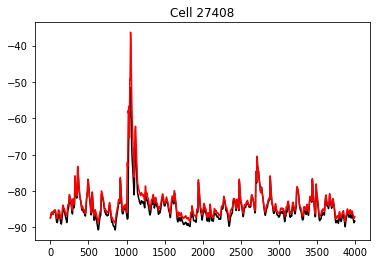

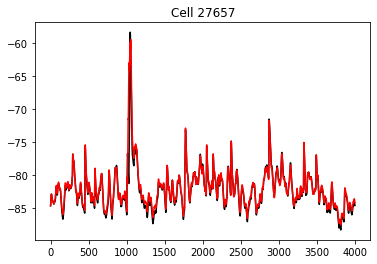

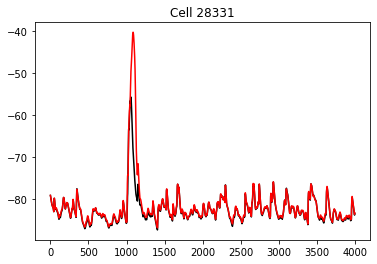

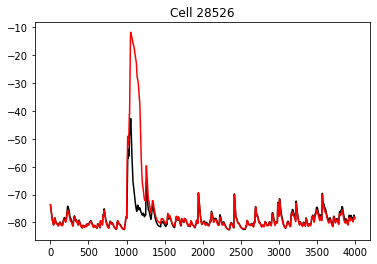

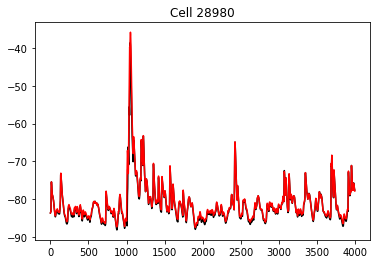

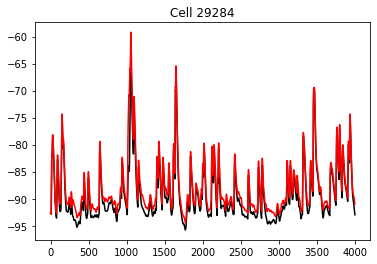

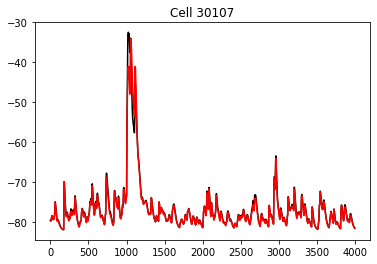

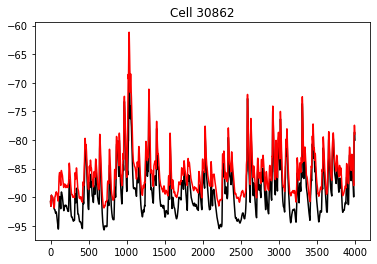

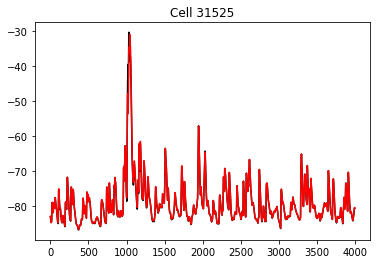

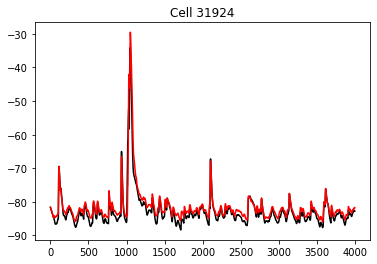

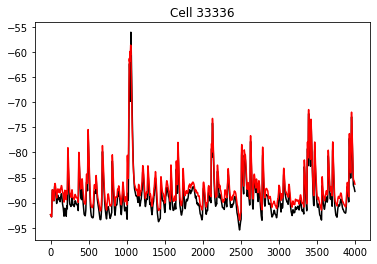

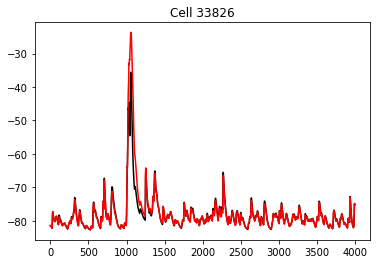

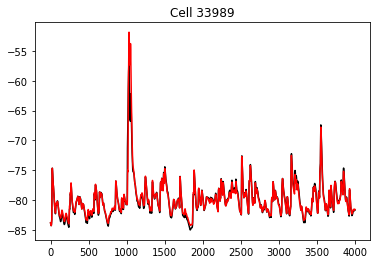

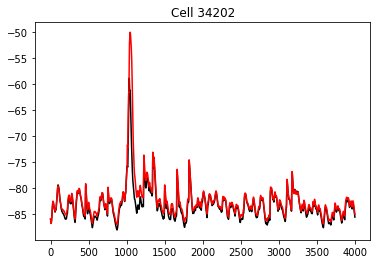

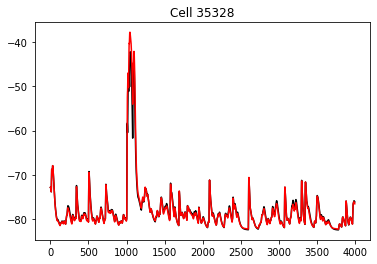

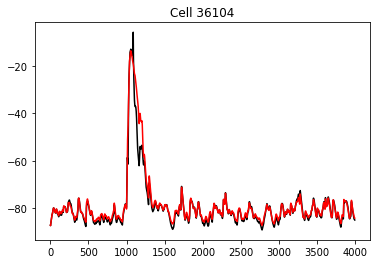

In [15]:
for s in sample_ids:
    plt.figure()
    plt.title(f"Cell {s}")
    for e, cells in dvoltage_synapse.items():

        for sec_id, data in cells[s].items():
            plt.plot(data['voltage'], c=colors[e])
            